1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Attack Strength (Epsilon): 0.01
Predicting Original...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Predicting Adversarial (Hacked)...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


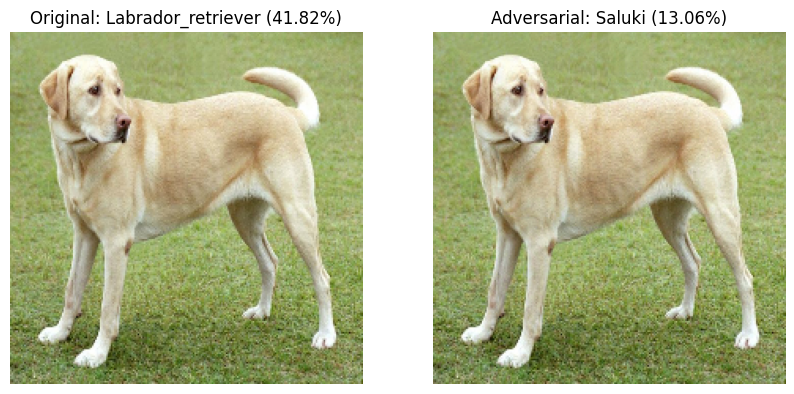

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
After Defense: Saluki (8.74%)


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# --- STEP 1: LOAD THE VICTIM MODEL (MobileNetV2) ---
# This is a lightweight model commonly used in mobile/IoT devices (Qualcomm Snapdragon chips).
model = tf.keras.applications.MobileNetV2(weights='imagenet')
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

# --- STEP 2: PREPARE THE IMAGE ---
# Helper function to preprocess the image so the AI can read it
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to display images
def display_images(original, adversarial, orig_pred, adv_pred):
  plt.figure(figsize=(10, 5))

  plt.subplot(1, 2, 1)
  plt.title(f"Original: {orig_pred[0][1]} ({orig_pred[0][2]*100:.2f}%)")
  plt.imshow(original[0] * 0.5 + 0.5) # Undo preprocessing for display
  plt.axis('off')

  plt.subplot(1, 2, 2)
  plt.title(f"Adversarial: {adv_pred[0][1]} ({adv_pred[0][2]*100:.2f}%)")
  plt.imshow(adversarial[0] * 0.5 + 0.5)
  plt.axis('off')
  plt.show()

# Download a sample image (Yellow Labrador)
image_path = tf.keras.utils.get_file('YellowLabrador.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
raw_image = tf.io.read_file(image_path)
image = tf.image.decode_image(raw_image)
image = preprocess(image)

# --- STEP 3: THE ATTACK (Fast Gradient Sign Method) ---
# This function calculates the "gradients" (direction) to push the pixels to confuse the AI
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

# Get the label of the original image (The "Truth")
preds = model.predict(image)
original_class_index = tf.argmax(preds[0])
label = tf.one_hot(original_class_index, preds.shape[-1])
label = tf.reshape(label, (1, preds.shape[-1]))

# Create the noise (perturbations)
perturbations = create_adversarial_pattern(image, label)

# --- STEP 4: APPLY THE HACK ---
# epsilon is the "strength" of the attack.
# 0.01 is very small (invisible to humans), but enough to fool the AI.
epsilon = 0.01
adv_x = image + (epsilon * perturbations)
adv_x = tf.clip_by_value(adv_x, -1, 1) # Keep pixel values valid

# --- STEP 5: VERIFY THE ATTACK ---
print(f"Attack Strength (Epsilon): {epsilon}")
print("Predicting Original...")
orig_preds = decode_predictions(model.predict(image), top=1)[0]
print("Predicting Adversarial (Hacked)...")
adv_preds = decode_predictions(model.predict(adv_x), top=1)[0]

# Show the evidence
display_images(image, adv_x, orig_preds, adv_preds)
# --- BONUS: DEFENSE (JPEG Compression) ---
# Simulating a defense mechanism by compressing the image to remove the "noise"
def defend_image(adv_image):
    # Convert to standard 0-255 format
    img_uint8 = tf.image.convert_image_dtype(adv_image[0] * 0.5 + 0.5, dtype=tf.uint8)
    # Encode as JPEG (lossy compression removes subtle attack noise)
    img_jpeg = tf.io.encode_jpeg(img_uint8, quality=75)
    # Decode back
    img_restored = tf.io.decode_jpeg(img_jpeg)
    img_restored = preprocess(img_restored)
    return img_restored

restored_img = defend_image(adv_x)
restored_preds = decode_predictions(model.predict(restored_img), top=1)[0]
print(f"After Defense: {restored_preds[0][1]} ({restored_preds[0][2]*100:.2f}%)")